In [1]:
import torch

import random
import argparse
import numpy as np
import ipdb as pdb
import os, pwd, yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from datetime import datetime
import sys
sys.path.append('..')
from LiLY.modules.CESM2 import CESM2ModularShiftsFixedB
from LiLY.tools.utils import load_yaml, setup_seed
from LiLY.modules import CESM2
from LiLY.datasets.sim_dataset import TimeVaryingDataset, FlexDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import Caulimate.Data.CESM2.dataset as CESM2_ds
import os
import warnings
warnings.filterwarnings('ignore')

from pytorch_lightning.loggers import WandbLogger
from Caulimate.Utils.Tools import lin_reg_init, check_tensor
from Caulimate.Utils.GraphUtils import eudistance_mask


REPO_Path = "/home/ff/Documents/climate"
DATA_PATH = os.path.join(REPO_Path, "CESM2")
SST_DATA_PATH = os.path.join(REPO_Path, "CESM2/CESM2_pacific_SST.pkl")
SPACE_INDEX_DATA_PATH = os.path.join(REPO_Path, "CESM2/CESM2_pacific.pkl")
GROUP_DATA_DIR = os.path.join(REPO_Path, "CESM2/group_region/")
XR_DATA_PATH = os.path.join(REPO_Path, "CESM2/CESM2_pacific_grouped_SST.nc")

SST_DATA_PATH = "/l/users/minghao.fu/CESM2/CESM2_pacific_SST.pkl"
SPACE_INDEX_DATA_PATH = "/l/users/minghao.fu/CESM2/CESM2_pacific.pkl"
GROUP_DATA_DIR = "/l/users/minghao.fu/dataset/CESM2/group_region/"
XR_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_grouped_SST.nc"

config = {
    "SEED": 42,
    "GRAPH_THRES": 0.01,
    "CHECKPOINT": "./model.ckpt",
    "DATASET": "seed_69_fixed_B_modular_4_2_6",
    "LOAD_CHECKPOINT": True,
    "LOG": "/home/minghao.fu/workspace/icml2024/log",
    "LOG_NAME": "diag",
    "MAX_EUD": 10,
    "MCC": {
        "CORR": "Pearson",
        "FREQ": 1.0
    },
    "PARALLEL": {
        "AREA_IDX": 0,
        "N_AREA": 10
    },
    "PROJ_NAME": "climate",
    "ROOT": "/home/minghao.fu/workspace/icml2024/LiLY/data",
    "SPLINE": {
        "BINS": 8,
        "BOUND": 5,
        "OBS_DIM": 1,
        "OBS_EMBED_DIM": 2,
        "ORDER": "linear"
    },
    "VAE": {
        "BETA": 0.002,
        "BIAS": False,
        "B_SPARSITY": 0.0001,
        "CPU": 8,
        "DEC": {
            "DIST": "gaussian",
            "HIDDEN_DIM": 128,
            "OBS_NOISE": False
        },
        "DYN_DIM": 6,
        "DYN_EMBED_DIM": 2,
        "ENC": {
            "HIDDEN_DIM": 128
        },
        "EPOCHS": 10000,
        "GAMMA": 0.02,
        "GPU": [0],
        "GRAD_CLIP": None,
        "INFER_MODE": "F",
        "INPUT_DIM": 6000,
        "LAG": 2,
        "LENGTH": 1,
        "LR": 0.001,
        "NCLASS": 12,
        "N_VAL_SAMPLES": 1024,
        "PIN": True,
        "SIMGA": 0.01,
        "TRAIN_BS": 64,
        "TRANS_PRIOR": "NP",
        "VAL_BS": 256
    }
}

cfg = config

pl.seed_everything(cfg['SEED'])

model = CESM2ModularShiftsFixedB.load_from_checkpoint(checkpoint_path=cfg['CHECKPOINT'], # if save hyperparameter
                                                         strict=False)
                                                         
# log_dir = os.path.join('.', cfg['PROJ_NAME'], cfg['DATASET'] + cfg['LOG_NAME'] + datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
# wandb_logger = WandbLogger(project=cfg['PROJ_NAME'], name=cfg['DATASET'] + cfg['LOG_NAME'] + datetime.now().strftime("%Y_%m_%d-%%M%S"))#, save_dir=log_dir)
# dataset = CESM2_ds.CESM2_grouped_dataset(XR_DATA_PATH, cfg['PARALLEL']['N_AREA'], ts_len=cfg['VAE']['LAG'] + cfg['VAE']['LENGTH'], n_domains=cfg['VAE']['NCLASS'])
# area_data = dataset[cfg['PARALLEL']['AREA_IDX']]
# cfg['VAE']['INPUT_DIM'] = area_data.d_X
# cfg['VAE']['NCLASS'] = area_data.n_domains

# eud_mask = eudistance_mask(area_data.coords, cfg['MAX_EUD'])
# B_init, mask = lin_reg_init(area_data.X, eud_mask)
# np.save('./B_init.npy', B_init)
# np.save('./coords.npy', area_data.coords)


Seed set to 42


In [3]:
model.

tensor([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1

In [2]:
from Caulimate.Utils.Visualization import plot_causal_graph, quick_map
from Caulimate.Utils.GraphUtils import decycle_till_dag

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import cartopy
import cartopy.crs as ccrs

B_init = np.load('./B_init.npy')
coords = np.load('./coords.npy')
coords[:, 1] = coords[:, 1] - 180
B_init_thres = B_init.copy()
B_init_thres[np.abs(B_init_thres) < 0.16] = 0
dag = decycle_till_dag(B_init_thres)

fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={'projection': ccrs.PlateCarree(180)},
)
time_idx = 1000
offset = 2
#ax.set_extent([np.min(coords[:, 1]) - offset, np.max(coords[:, 1]) + offset, np.min(coords[:, 0]) - offset, np.max(coords[:, 0]) + offset], crs=ccrs.PlateCarree())
#ax.set_extent([-180,180,-90,90])
# ax.stock_img()
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)

plot_causal_graph(coords, dag, ax, plot_node_index=False)
plt.show()

: 

In [ ]:
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()
print(f"x limits: {x_limits}")
print(f"y limits: {y_limits}")
extent = ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]

x limits: (43.84285851449939, 105.49)
y limits: (-11.24160788791665, 8.200945633169892)


(43.84285851449939, 105.49, -11.24160788791665, 8.200945633169892)

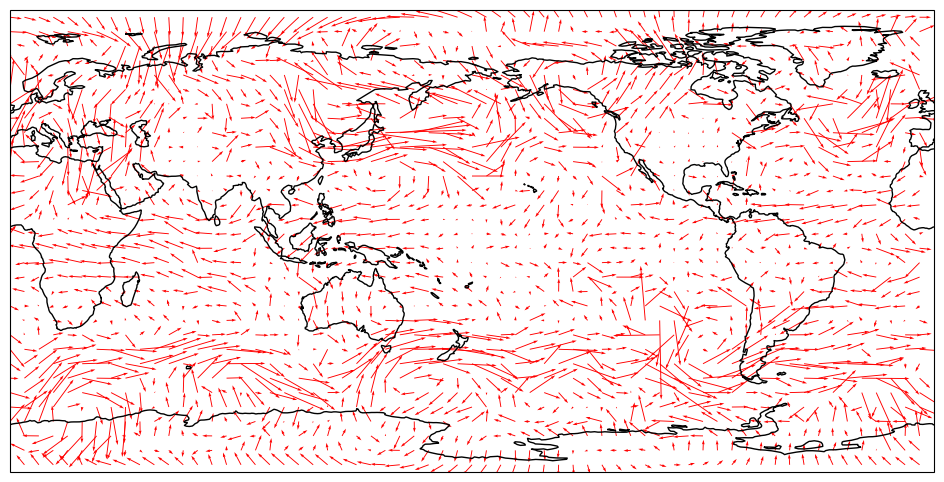

In [ ]:
# wind_vector.py
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from Caulimate.Utils.Visualization import plot_causal_graph
from Caulimate.Utils.Tools import recover_coordinates

u = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/u_component_of_wind/*.nc', combine='by_coords')
v = xr.open_mfdataset('/l/users/minghao.fu/dataset/WeatherBench_data_full/v_component_of_wind/*.nc', combine='by_coords')

u = recover_coordinates(u)
v = recover_coordinates(v)

v_slice = v.isel(time=time_idx).sel(level=850)['v']
u_slice = u.isel(time=time_idx).sel(level=850)['u']

lon = u_slice.coords['lon']
lat = u_slice.coords['lat']

# Plotting
plt.figure(figsize=(14, 6))
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.coastlines()
# extent = [ax.get_xlim()[0], ax.get_xlim()[1], ax.get_ylim()[0], ax.get_ylim()[1]]
# ax.set_extent(extent)
plt.quiver(lon, lat, u_slice, v_slice, scale=500, color='red', width=0.001)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

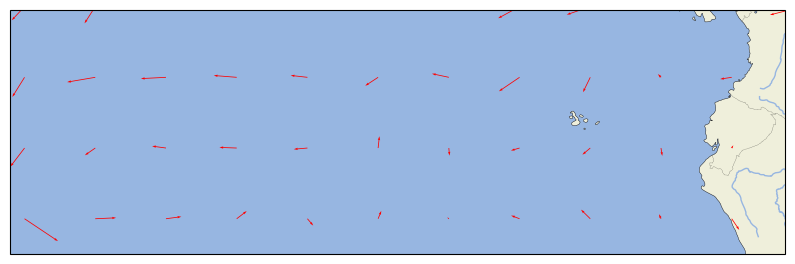

In [ ]:
# Redraw the figure with the new extent
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw={'projection': ccrs.PlateCarree(180)},
)

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
ax.add_feature(cartopy.feature.RIVERS)
# Reduce the scale to make the arrows longer
plt.quiver(lon, lat, u_slice, v_slice, scale=200, color='red', width=0.001)

# Set the extent
ax.set_extent(extent, crs=ccrs.PlateCarree(180))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:

cfg = load_yaml('../LiLY/configs/CESM2.yaml')

train_data = dataset.CESM2_grouped_dataset(XR_DATA_PATH, num_area=NUM_AREA)
CESM2_coords = np.zeros((train_data.n_groups, 2))
CESM2_adj_mats = []
CESM2_group_indices = np.zeros(train_data.n_groups)
CESM2_treatment_effects = np.zeros((TEST_SIZE, cfg['VAE']['DYN_DIM'] + cfg['SPLINE']['OBS_DIM'], train_data.n_groups))
CESM2_area_te_lst = []
zs_lst = []
group_accumulator = 0

for area_idx in range(NUM_AREA):
    area_train_data = train_data[area_idx]
    # fixed for a specific area
    cfg['VAE']['INPUT_DIM'] = area_train_data.d_X
    cfg['VAE']['NCLASS'] = area_train_data.n_domains

    if area_train_data.d_X > 1000:
        B_init = large_scale_linear_regression_initialize(area_train_data.data['xt'].reshape(-1, cfg['VAE']['INPUT_DIM']))
    else:
        B_init = check_tensor(linear_regression_initialize(area_train_data.data['xt'].reshape(-1, cfg['VAE']['INPUT_DIM'])), dtype=torch.float32)
    train_loader = DataLoader(area_train_data, batch_size=TEST_SIZE, shuffle=True, pin_memory=not torch.cuda.is_available())

    #model = CESM2ModularShiftsFixedB.load_from_checkpoint(map_location=torch.device('cpu'), checkpoint_path=CKP_PATH)
    model = CESM2ModularShiftsFixedB(input_dim=cfg['VAE']['INPUT_DIM'],
                                length=cfg['VAE']['LENGTH'],
                                obs_dim=cfg['SPLINE']['OBS_DIM'],
                                dyn_dim=cfg['VAE']['DYN_DIM'],
                                lag=cfg['VAE']['LAG'],
                                nclass=cfg['VAE']['NCLASS'],
                                hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                                dyn_embedding_dim=cfg['VAE']['DYN_EMBED_DIM'],
                                obs_embedding_dim=cfg['SPLINE']['OBS_EMBED_DIM'],
                                trans_prior=cfg['VAE']['TRANS_PRIOR'],
                                lr=cfg['VAE']['LR'],
                                infer_mode=cfg['VAE']['INFER_MODE'],
                                bound=cfg['SPLINE']['BOUND'],
                                count_bins=cfg['SPLINE']['BINS'],
                                order=cfg['SPLINE']['ORDER'],
                                beta=cfg['VAE']['BETA'],
                                gamma=cfg['VAE']['GAMMA'],
                                sigma=cfg['VAE']['SIMGA'],
                                B_sparsity=cfg['VAE']['B_SPARSITY'],
                                decoder_dist=cfg['VAE']['DEC']['DIST'],
                                correlation=cfg['MCC']['CORR'],
                                B_init=B_init)
    model.eval()
    batch = next(iter(train_loader))
    batch_size = batch['xt'].shape[0]
    
    mus, logvars, x_recon, y_recon, zs, Bs, coords = model.forward(batch)
    zs, _, _, _ = whiten_data(check_array(zs[:, -1, :]))
    
    if area_idx == 0:
        zs_center = zs
    else:
        _, zs = align_two_latents(zs_center, zs)

    latent_size =  zs.shape[-1]
    mus = mus.view(batch_size, -1, latent_size)
    logvars = logvars.view(batch_size, -1, latent_size)
    y_recon = y_recon.view(batch_size, -1, cfg['VAE']['INPUT_DIM'])
    
    Bs = check_array(Bs)
    x_recon = check_array(x_recon)
    y_recon = check_array(y_recon)

    # Bs[Bs < threshold] = 0
    # supper_B = np.all(Bs > 0, axis=0)
    supper_B = check_array(B_init)
    supper_B[np.abs(B_init) < DAG_THRES] = 0    
    supper_B, _ = threshold_till_dag(supper_B)

    #plt.savefig(f'./files/supper_B/map.png')
    #xr_data.isel(time=0).plot(x='lon', y='lat', ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
    CESM2_adj_mats.append(supper_B)
    CESM2_coords[group_accumulator : group_accumulator + area_train_data.d_X] = check_array(area_train_data.coords)
    CESM2_group_indices[group_accumulator : group_accumulator + area_train_data.d_X] = check_array(area_train_data.group_index)
    # Treatment Effect
    zs = check_tensor(zs, dtype=torch.float32).clone()
    x_recon = model.net._decode(zs)
    z_effects = []
    for i in range(zs.shape[-1]):
        zi = zs.clone()
        zi[:, i] = 0
        zi_effect = x_recon - model.net._decode(zi)
        CESM2_treatment_effects[:, i, group_accumulator : group_accumulator + area_train_data.d_X] = check_array(zi_effect)
    group_accumulator += area_train_data.d_X

NameError: name 'makedir' is not defined

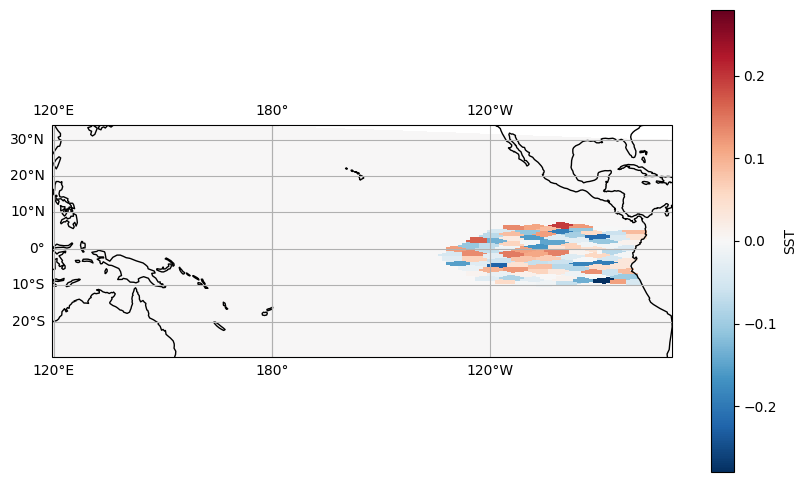

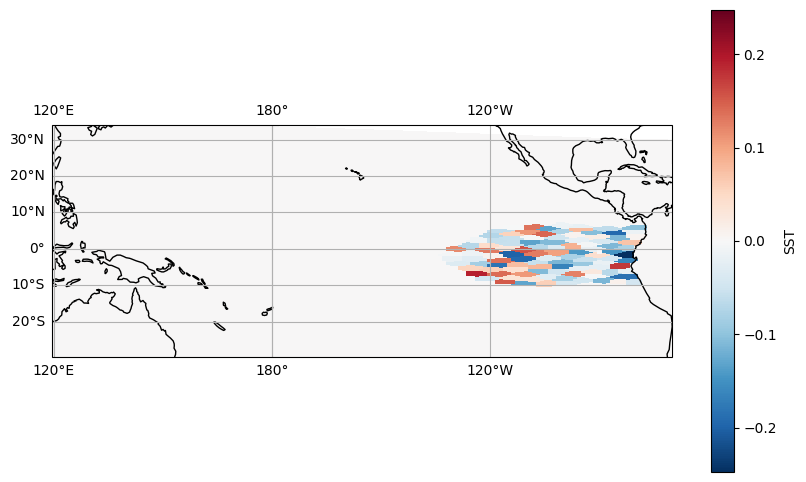

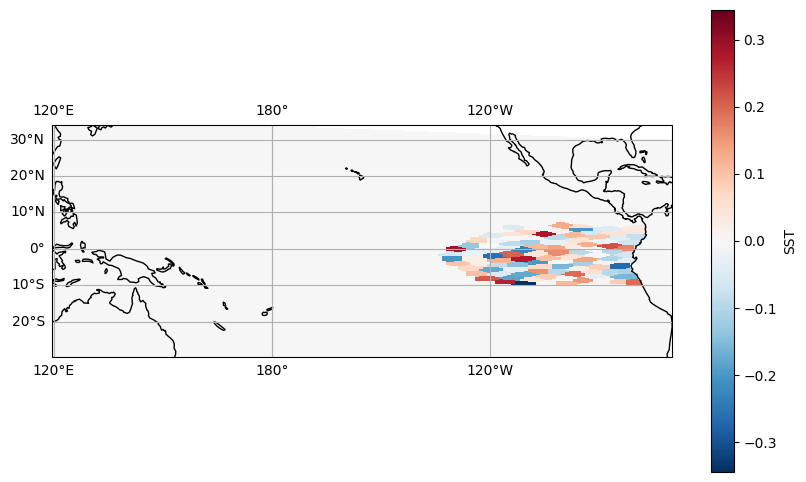

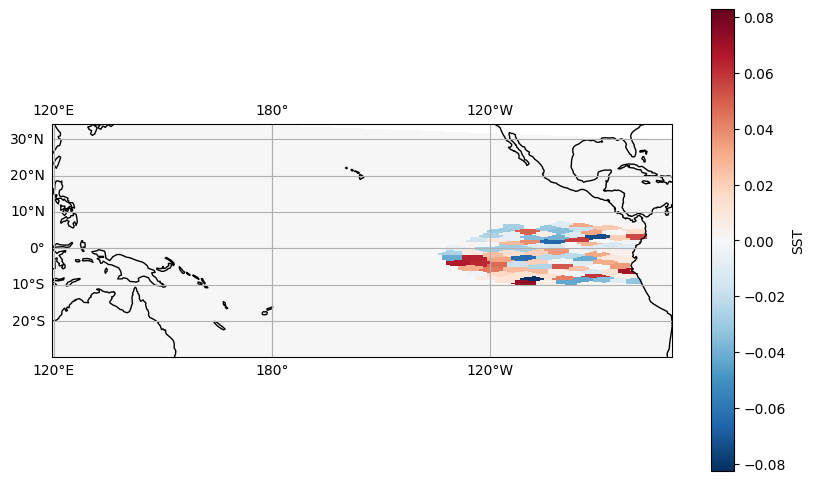

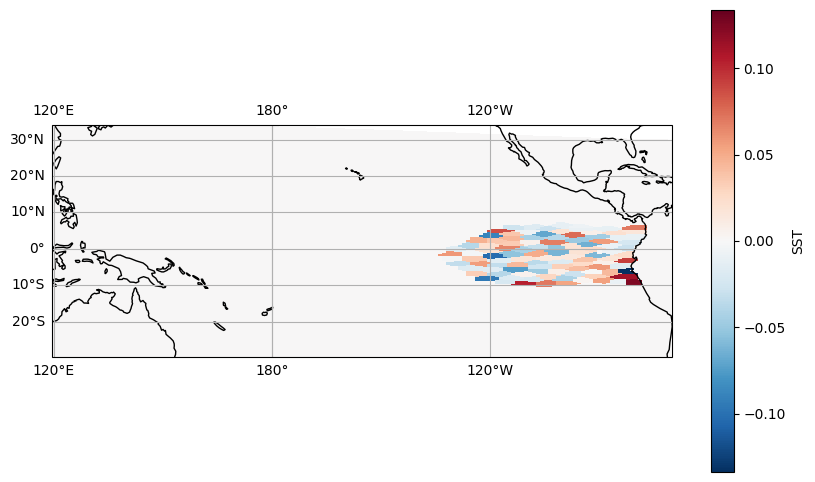

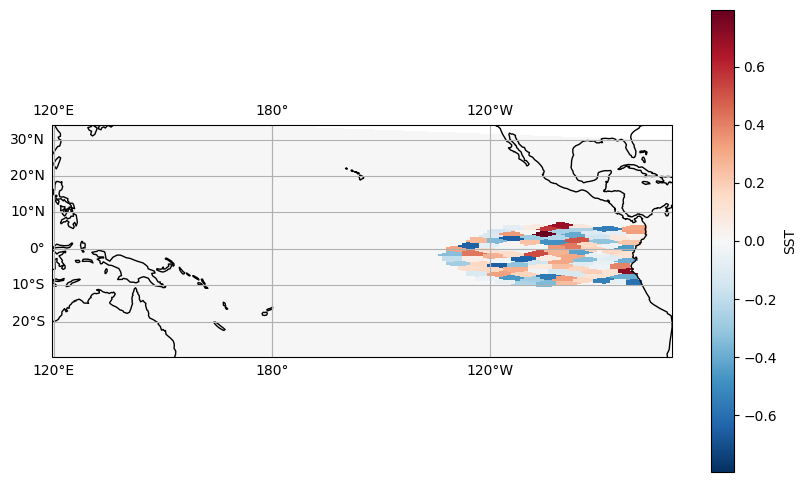

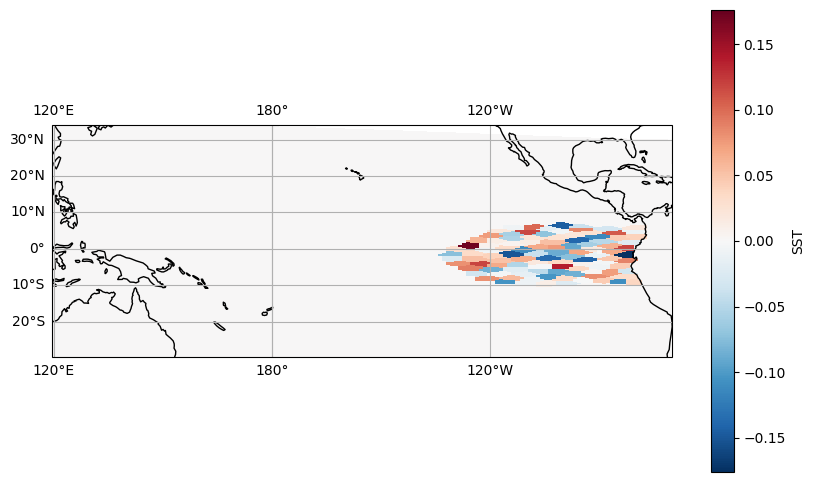

In [ ]:

norms = np.linalg.norm(CESM2_treatment_effects, axis=-1, keepdims=True)
normalized_effects = CESM2_treatment_effects# / norms
xr_te_lst = []
for z_idx in range(CESM2_treatment_effects.shape[1]):
    xr_te_i = xr.zeros_like(train_data.xr_ds).isel(time=TIME_IDX)
    for idx, agroup_index in enumerate(CESM2_group_indices):
        mask = train_data.xr_ds.group_index == agroup_index
        # Assign values based on the mask
        group_value = normalized_effects[TIME_IDX, z_idx, idx]  
        xr_te_i.values[mask] = normalized_effects[TIME_IDX, z_idx, idx]  
        
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree(-120)})
    #plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1, wspace=0.2, hspace=0.2)
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    xr_te_i.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree())
    fig.savefig(f'./CESM2/treatment_effect/z{z_idx}.png', dpi=500)
    # save z_i treatment effects
    xr_te_lst.append(xr_te_i)

In [ ]:
zs.shape

torch.Size([100, 7])